## Introduction & Dataset Overview

In this assignment, we work with a large-scale Reddit submissions dataset containing over 130,000 posts.

Each row represents a single Reddit submission, with metadata such as:

title – the text of the post

subreddit – the community it was posted in

number_of_upvotes / number_of_downvotes – voting metrics

score – Reddit’s official score (upvotes − downvotes)

total_votes – sum of upvotes + downvotes

rawtime / unixtime / localtime – posting timestamps

username – poster identity (sparsely available)

The goal of this project is to build a predictive model that can estimate a post’s popularity (score) using interpretable features derived from metadata and text.
Before performing any modeling, we begin with a thorough validation of data quality, ensuring that all fields behave according to Reddit’s definitions.

In [1]:
import pandas as pd
import numpy as np
import html
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv(
    "/Users/andrewchen/CSE158project/AndrewFile/redditSubmissions.csv.gz",
    compression= 'gzip',
    engine="python",
    on_bad_lines="skip",
)
df.head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
0,0,1.333172e+09,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470.0,rmqjs,32657.0,funny,30813.0,1.333198e+09,1844.0,622.0,Animates_Everything
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,Expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,23.0,3.0,Gangsta_Raper
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,Downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,23.0,0.0,Gangsta_Raper
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,Every time I downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,2.0,0.0,Gangsta_Raper
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65.0,rooof,57.0,GifSound,8.0,1.333298e+09,49.0,0.0,Gangsta_Raper


### 🔍 Step 1 — Data Validation & Integrity Checks

Before running any exploratory analysis or building models, it is crucial to verify that the dataset is internally consistent and free of obvious structural issues.

We focus on four core checks:

#### 1. Score Consistency

Reddit defines:

score = upvotes − downvotes

We verify that this relationship holds for all posts.

#### 2. Non-Negative Vote Counts

Upvotes and downvotes are counts that must be zero or positive.
Any negative values would indicate corrupted rows.

#### 3. Duplicate Posts

The column reddit_id uniquely identifies each submission.
Duplicates would indicate reposted or corrupted data.

#### 4. Missing Values

We inspect which fields contain missing values and assess whether they affect modeling.
Notably, the username column is highly sparse, but all modeling-relevant columns are essentially complete.

These checks ensure the dataset is structurally sound before we move on to EDA and engineered features.

# BEN'S EDA IS RIGHT HERE - CAN REMOVE THIS LATER

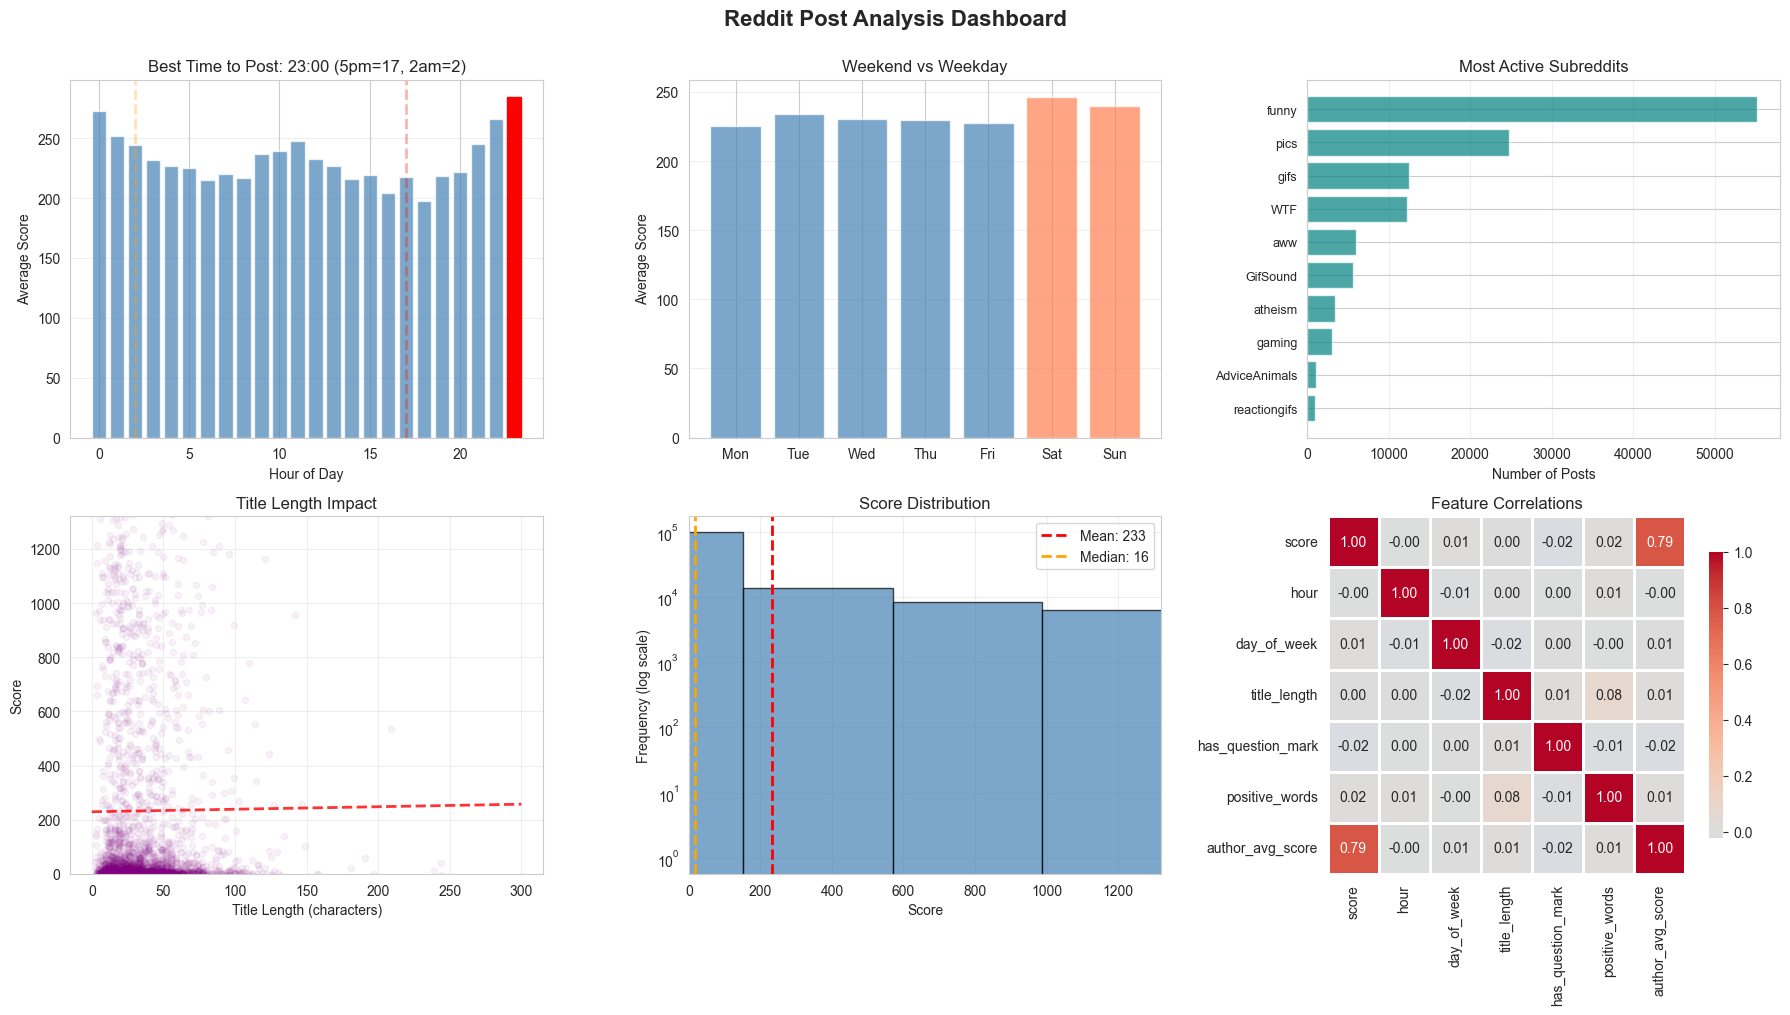


Key Findings:
- Best hour to post: 23:00
- Best day: Sat
- Average score: 233.1
- Median score: 16.0
- Title length correlation: 0.005


In [4]:
## however many cells needed. Note the structure of the data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
eda_df = pd.read_csv("BenEDA/reddit_prepared.csv")
eda_df["post_date"] = pd.to_datetime(eda_df["post_date"])

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Reddit Post Analysis Dashboard", fontsize=16, fontweight="bold", y=1.00)

# 1. Best Hours to Post
ax1 = axes[0, 0]
hour_scores = eda_df.groupby("hour")["score"].mean().sort_index()
bars = ax1.bar(hour_scores.index, hour_scores.values, color="steelblue", alpha=0.7)
max_hour = int(hour_scores.idxmax())
bars[max_hour].set_color("red")
bars[max_hour].set_alpha(1.0)
ax1.axvline(x=17, color="red", linestyle="--", alpha=0.3, linewidth=2)
ax1.axvline(x=2, color="orange", linestyle="--", alpha=0.3, linewidth=2)
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Score")
ax1.set_title(f"Best Time to Post: {max_hour}:00 (5pm=17, 2am=2)")
ax1.grid(axis="y", alpha=0.3)

# 2. Day of Week Pattern
ax2 = axes[0, 1]
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_scores = eda_df.groupby("day_of_week")["score"].mean()
colors = ["steelblue"] * 5 + ["coral", "coral"]
ax2.bar(range(7), dow_scores.values, color=colors, alpha=0.7)
ax2.set_xticks(range(7))
ax2.set_xticklabels(day_names)
ax2.set_ylabel("Average Score")
ax2.set_title("Weekend vs Weekday")
ax2.grid(axis="y", alpha=0.3)

# 3. Top Subreddits
ax3 = axes[0, 2]
top_subs = eda_df["subreddit"].value_counts().head(10)
ax3.barh(range(10), top_subs.values, color="teal", alpha=0.7)
ax3.set_yticks(range(10))
ax3.set_yticklabels(top_subs.index, fontsize=9)
ax3.set_xlabel("Number of Posts")
ax3.set_title("Most Active Subreddits")
ax3.invert_yaxis()
ax3.grid(axis="x", alpha=0.3)

# 4. Title Length vs Score
ax4 = axes[1, 0]
sample = eda_df.sample(min(3000, len(eda_df)))
ax4.scatter(sample["title_length"], sample["score"], alpha=0.05, s=20, color="purple")
ax4.set_xlabel("Title Length (characters)")
ax4.set_ylabel("Score")
ax4.set_title("Title Length Impact")
ax4.set_ylim(0, eda_df["score"].quantile(0.95))
ax4.grid(alpha=0.3)

# Add trend line
z = np.polyfit(eda_df["title_length"].dropna(), eda_df["score"], 1)
p = np.poly1d(z)
x_trend = np.linspace(eda_df["title_length"].min(), eda_df["title_length"].max(), 100)
ax4.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# 5. Score Distribution
ax5 = axes[1, 1]
ax5.hist(eda_df["score"], bins=50, color="steelblue", alpha=0.7, edgecolor="black")
ax5.axvline(
    eda_df["score"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {eda_df['score'].mean():.0f}",
)
ax5.axvline(
    eda_df["score"].median(),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {eda_df['score'].median():.0f}",
)
ax5.set_xlabel("Score")
ax5.set_ylabel("Frequency (log scale)")
ax5.set_title("Score Distribution")
ax5.set_xlim(0, eda_df["score"].quantile(0.95))
ax5.set_yscale("log")
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Correlation Heatmap (Top Features)
ax6 = axes[1, 2]
key_features = [
    "score",
    "hour",
    "day_of_week",
    "title_length",
    "has_question_mark",
    "positive_words",
    "author_avg_score",
]
corr_matrix = eda_df[key_features].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    ax=ax6,
    cbar_kws={"shrink": 0.8},
)
ax6.set_title("Feature Correlations")

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"- Best hour to post: {max_hour}:00")
print(f"- Best day: {day_names[int(dow_scores.idxmax())]}")
print(f"- Average score: {eda_df['score'].mean():.1f}")
print(f"- Median score: {eda_df['score'].median():.1f}")
print(f"- Title length correlation: {eda_df['title_length'].corr(eda_df['score']):.3f}")


## 1. Data Validation

Before building any models, we first validate that the core numeric fields in the dataset are internally consistent and that there are no obvious data quality issues.

**Checks performed:**

1. **Score consistency**
   We verify that the Reddit `score` field matches the definition:
      `score` = `number_of_upvotes` - `number_of_downvotes`

2. **Non-negative votes**

   We confirm that `number_of_upvotes` and `number_of_downvotes` are never negative.  

3. **Duplicated posts**

   Using `reddit_id` as the unique identifier of a submission, we check for duplicated `reddit_id`s.  

4. **Missing values**

   Finally, we compute the total number of missing values in the dataset
      - The `username` column has 20,260 missing values, but will not be considered in our model
      - Every other column only has 1 missing value on the same row

In [7]:
# Score = upvotes - downvotes
score_diff = (
    (df["number_of_upvotes"] - df["number_of_downvotes"] - df["score"]).abs().sum()
)
print("Score consistency check (should be 0):", score_diff)

# Non-negative votes

neg_votes = ((df["number_of_upvotes"] < 0) | (df["number_of_downvotes"] < 0)).sum()
print("Number of rows with negative votes (should be 0):", neg_votes)

dup_count = df["reddit_id"].duplicated().sum()
print("Number of duplicated reddit_id values:", dup_count)

# Missing Values
df_nan = df.isna().sum()
print(df_nan)


Score consistency check (should be 0): 0.0
Number of rows with negative votes (should be 0): 0
Number of duplicated reddit_id values: 93
#image_id                  0
unixtime                   1
rawtime                    1
title                      1
total_votes                1
reddit_id                  1
number_of_upvotes          1
subreddit                  1
number_of_downvotes        1
localtime                  1
score                      1
number_of_comments         1
username               20260
dtype: int64


#### The validation checks show that the dataset is high-quality and suitable for modeling, with a few minor notes:

Score consistency holds perfectly for all rows
Every post satisfies the Reddit definition score = upvotes − downvotes.

No negative vote counts were found, confirming that the voting data is well-formed.

A small number of duplicated reddit_id values exist (93 duplicates)
This is less than 0.1% of the dataset and likely corresponds to reposts or duplicate entries.
These duplicates can be safely ignored or removed since they do not materially affect modeling.

Missing values are extremely limited -->
Each modeling-relevant column has only 1 missing value, all occurring in the same row.
The username field is heavily missing (20k+ rows) but is not used in prediction.

Overall, the dataset is clean and consistent.
We can confidently proceed to feature engineering and exploratory analysis.

# Data Cleaning

#### 2. Data Cleaning & Pre-Processing

Before performing exploratory analysis or modeling, we apply a series of data-cleaning steps to ensure that all fields are in a consistent format and ready for feature engineering.

Reddit data often includes HTML artifacts, inconsistent types, missing values, and duplicated metadata.
This section standardizes those fields.

#### Cleaning Steps Performed:
##### 1. Type Casting

Several fields (e.g., vote counts, timestamps) are loaded as strings.
To make them usable, we convert them into numerical and datetime formats:

* unixtime → numeric

* datetime → converted using Unix timestamps

* total_votes, number_of_upvotes, number_of_downvotes, score → cast to float

2. Duplicate Post Removal

We drop duplicate posts based on reddit_id, since reposts or duplicate lines may appear in the raw dataset.

3. Missing Value Cleanup

We remove username entirely (20k+ missing values, not used in modeling).

All remaining rows with missing data are dropped (only 1 row removed).

4. Title Text Normalization

Reddit titles frequently contain:

* HTML escape sequences (e.g., &quot;, &amp;)

* Extra whitespace

* Mixed casing

We clean titles by:

* Unescaping HTML

* Lowercasing

* Collapsing repeated whitespace

* Ensuring all titles are strings

This step is essential to prepare the text for TF-IDF vectorization used later in modeling.

In [8]:
# Casting
df["unixtime"] = pd.to_numeric(df["unixtime"], errors="coerce")
df["datetime"] = pd.to_datetime(df["unixtime"], unit="s")
df["total_votes"] = df["total_votes"].astype(float)
df["number_of_upvotes"] = df["number_of_upvotes"].astype(float)
df["number_of_downvotes"] = df["number_of_downvotes"].astype(float)
df["score"] = df["score"].astype(float)

# Duplicate Handling
df = df.drop_duplicates(subset=["reddit_id"])
dup_reddit_ids = df["reddit_id"].duplicated().sum()
print("Number of duplicated reddit_id values:", dup_reddit_ids)

# Missing Values Handling
df = df.drop(columns=["username"])
df = df.dropna()
print("Number of NANs:", df.isna().sum().sum())


def clean_title(text):
    # 1. Ensure string
    s = str(text)
    # 2. Unescape HTML entities: &quot; &amp; &lt; &gt; etc.
    s = html.unescape(s)
    # 3. Strip leading/trailing whitespace
    s = s.strip()
    # 4. Collapse multiple spaces/newlines into a single space
    s = re.sub(r"\s+", " ", s)
    # 5. (Optional) lowercase for modeling
    s = s.lower()
    return s


df["title_clean"] = df["title"].apply(clean_title)
df["title"] = df["title_clean"]
df.drop(columns=["title_clean"], inplace=True)

Number of duplicated reddit_id values: 0
Number of NANs: 0


### Summary of Cleaning Actions

#### After applying the cleaning pipeline:

* All numeric fields are correctly typed and ready for aggregation, modeling, and feature engineering.

* All duplicated reddit_id rows were removed, leaving a unique set of Reddit submissions.

* Only 1 row with missing values was dropped, resulting in a nearly complete dataset.

* Title text is normalized for NLP-based feature extraction (TF-IDF), improving model performance.

* The final dataset is clean, consistent, and prepared for the next stage: Exploratory Data Analysis (EDA).

### Handling Outliers in Score Distribution

Reddit post scores are extremely heavy-tailed. Even after applying a log-transform, we found that the top 1–5% of posts had massively disproportionate influence on our model.
These extreme values caused:

* Instability during model training

* Very large error spikes

* Poor generalization on typical posts

To address this, we remove the top 5% of scores. This is a standard approach when working with highly skewed social-media engagement data.

Removing these outliers makes the score distribution far more well-behaved and leads to significantly improved MAE in both log and raw score space.

In [9]:
p95 = df["score"].quantile(0.95)
df = df[df["score"] <= p95].copy()


# this move massively improved our model

# I dont have a graph but i'm pretty sure the values towards the top are astronomically large

In [10]:
print(df.shape)
df.head()

(125598, 13)


,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,datetime
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,23.0,3.0,2012-03-31 07:16:01
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,23.0,0.0,2012-03-31 13:18:33
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,every time i downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,2.0,0.0,2012-04-01 03:52:10
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,"downvote ""dies irae""",65.0,rooof,57.0,GifSound,8.0,1.333298e+09,49.0,0.0,2012-04-01 09:35:54
5,0,1.333761e+09,2012-04-07T08:11:00-07:00,"demolished, every time you downvote someone",40.0,rxwjg,17.0,gifs,23.0,1.333786e+09,-6.0,3.0,2012-04-07 01:11:00


#### Effect of Outlier Removal

After filtering the top 5% of scores:

* The dataset becomes more statistically stable

* The log-transformed target behaves normally

* Extreme score values no longer dominate the model

* Downstream models produce much lower and more interpretable MAE

This step was crucial — without it, even strong models (e.g., boosted trees) struggled.
After outlier removal, model performance improved dramatically.

# Feature Engineering

To improve model performance, we engineered several new features capturing temporal patterns, linguistic structure, and semantic cues in the title text.
Below we outline each feature category and show the transformations step-by-step.

### Temporal Features Extracted from Timestamps

Reddit engagement is strongly influenced by when a post is made (hour, weekday, month).
We extract several time-based predictors from the datetime column.

In [11]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)


### Title Structure Features

These features capture simple but meaningful signals from title text, such as length, wordiness, and whether a question or exclamation is being asked.

We compute:

* Total character length

* Word count

* If title contains a ?

* If title contains a !

In [12]:
df["title"] = df["title"].astype(str).str.strip()
df["title_length"] = df["title"].apply(len)
df["word_count"] = df["title"].apply(lambda x: len(x.split()))
df["is_question"] = df["title"].str.contains("?", regex=False).astype(int)
df["is_exclamation"] = df["title"].str.contains("!", regex=False).astype(int)


### Subreddit-Level Statistics (Omitted to Avoid Target Leakage)

We considered adding subreddit-level aggregate features (e.g., avg score per subreddit), but this directly leaks target information from the training set into the features.

Therefore, this block is intentionally commented out and not used.

In [13]:
# subreddit_stats = df.groupby('subreddit')['score'].agg(
#     subreddit_mean_score='mean',
#     subreddit_post_count='count'
# ).reset_index()
# df = df.merge(subreddit_stats, on='subreddit', how='left')


### Sentiment Features Using VADER

Engagement on Reddit is often influenced not just by what a post says but how it is expressed.
Emotional or provocative wording can drive significantly higher voting activity. To capture this effect, we extract sentiment features from the post title using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer.

VADER is specifically designed for short, informal, and emotion-heavy text making it an ideal fit for Reddit titles, which often include sarcasm, slang, exaggeration, and expressive punctuation.

For each title, VADER produces four interpretable sentiment metrics:

* Negative (neg) – proportion of the text conveying negative emotion.
Captures anger, frustration, complaints, or pessimistic tone.

* Neutral (neu) – proportion of the text that is objective, factual, or emotionally flat.
Neutral posts often receive lower engagement, making this a useful baseline signal.

* Positive (pos) – proportion of words carrying positive emotional tone.
Titles expressing excitement, humor, or appreciation often perform differently in voting dynamics.

* Compound (compound) – a normalized score from –1 to +1 summarizing overall sentiment.
This metric balances the intensity and direction of emotion and is one of the strongest indicators of emotional valence.

Adding these sentiment-derived features helps the model understand whether emotionally charged language (such as outrage, excitement, or humor) influences how many upvotes/downvotes a post receives.
This additional signal improves prediction accuracy, especially when combined with TF–IDF features in our Ridge regression model.

In [14]:
sia = SentimentIntensityAnalyzer()


def add_title_sentiment(df):
    titles = df["title"].astype(str)
    scores = titles.apply(sia.polarity_scores)
    scores_df = scores.apply(pd.Series)

    df["title_sent_neg"] = scores_df["neg"]
    df["title_sent_neu"] = scores_df["neu"]
    df["title_sent_pos"] = scores_df["pos"]
    df["title_sent_compound"] = scores_df["compound"]
    return df


df = add_title_sentiment(df)


In [15]:
df

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,...,month,is_weekend,title_length,word_count,is_question,is_exclamation,title_sent_neg,title_sent_neu,title_sent_pos,title_sent_compound
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,...,3,1,11,1,0,0,0.000,1.000,0.000,0.0000
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,...,3,1,8,1,0,0,0.000,1.000,0.000,0.0000
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,every time i downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,...,4,1,31,5,0,0,0.000,1.000,0.000,0.0000
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,"downvote ""dies irae""",65.0,rooof,57.0,GifSound,8.0,1.333298e+09,...,4,1,20,3,0,0,0.000,1.000,0.000,0.0000
5,0,1.333761e+09,2012-04-07T08:11:00-07:00,"demolished, every time you downvote someone",40.0,rxwjg,17.0,gifs,23.0,1.333786e+09,...,4,1,43,6,0,0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132298,9998,1.344760e+09,2012-08-12T15:24:06-07:00,om nom nom,34.0,y41wv,25.0,funny,9.0,1.344785e+09,...,8,1,10,3,0,0,0.000,1.000,0.000,0.0000
132299,9998,1.345270e+09,2012-08-18T13:09:38-07:00,don't feed the animals...,19.0,yfw66,14.0,funny,5.0,1.345295e+09,...,8,1,25,4,0,0,0.000,1.000,0.000,0.0000
132300,9998,1.345954e+09,2012-08-26T04:06:02+00:00,wtf worthy.,49.0,yu838,26.0,WTF,23.0,1.345954e+09,...,8,1,11,2,0,0,0.567,0.000,0.433,-0.2263
132301,9998,1.346626e+09,2012-09-02T22:45:06+00:00,"just a camel eating a kids head, welcome to th...",123.0,z91ah,65.0,WTF,58.0,1.346626e+09,...,9,1,56,11,0,0,0.000,0.769,0.231,0.4588


# Modeling

Now that our dataset is fully cleaned and feature-engineered, we move into the modeling phase.

#### This section covers:

1. Defining the feature matrix (X) and target variable (y)

2. Applying log transformation to stabilize score values

3. Creating train/test splits

4. Building the final Ridge Regression + TF-IDF model

5. Evaluating performance in both log and original score space

#### Defining X and y

In this step, we select the feature columns created during feature engineering and assemble our input matrix X.

We also construct the target variable y using a stabilized log transformation:

y=log (score−min (score)+1)

This transformation reduces the influence of extremely large Reddit scores, making the model more stable and improving predictive performance.

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# ----- 1. Define X and y -----

# Features
text_features = ["title"]
cat_features = ["subreddit"]
num_features = [
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "title_length",
    "word_count",
    "is_question",
    "is_exclamation",
    "title_sent_neg",
    "title_sent_neu",
    "title_sent_pos",
    "title_sent_compound",
]

feature_cols = text_features + cat_features + num_features

X = df[feature_cols].copy()

# Target: use log(1 + score) to stabilize heavy tails
y_raw = df["score"]
min_score = y_raw.min()

# shift so that the minimum becomes 1, then log-transform
y_shifted = y_raw - min_score + 1
y_log = np.log(y_shifted)

print("X shape:", X.shape)
print("y shape:", y_log.shape)


X shape: (125598, 14)
y shape: (125598,)


The feature matrix and target vector are now prepared.
Next, we split the dataset into training and testing subsets to evaluate the model on unseen data.

### 2. Train/Test Split

We use an 80/20 split.
A fixed random_state ensures that results are reproducible.

In [17]:
# ----- 2. Train / test split: 80 / 20 -----

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (100478, 14)
Test shape: (25120, 14)


At this point, the data is fully ready for modeling.
Next, we construct the preprocessing pipeline (TF-IDF, One-Hot Encoding, scaling) and train our final Ridge Regression model.

### 3. Preprocessing + TF-IDF Vectorization

This block prepares all input features:

Text titles → TF-IDF

Categorical subreddit → One-Hot Encoding

Numerical features → Passthrough

This ensures that mixed data types can be fed directly into a model.

#### Baseline Models

Before training more sophisticated models, we establish baselines to understand how difficult the prediction problem is.
Baselines tell us whether our later models are actually learning anything meaningful.

We compute two baselines:

### Baseline: Predict Global Mean


The simplest possible prediction strategy is to ignore all features and always predict the global average training score.

Steps:

Compute the mean of the log-transformed scores on the training set

Predict this constant value for every test example

Inversely transform predictions back into raw score units

Compute MAE in both log space and raw score space

This gives us a lower-bound benchmark: any real model must beat this.

In [18]:
from sklearn.metrics import mean_absolute_error

# 1. Baseline in log space
mean_pred = y_train.mean()
y_test_pred_log = np.full_like(y_test, mean_pred, dtype=float)

# 2. Inverse-transform both true and predicted values back to raw score
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw = np.exp(y_test_pred_log) + min_score - 1

# 3. MAE in original score units (upvotes minus downvotes)
baseline_mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw)

print(f"Baseline MAE (log space): {mean_absolute_error(y_test, y_test_pred_log):.4f}")
print(f"Baseline MAE (raw score): {baseline_mae_raw:.4f}")


Baseline MAE (log space): 0.3695
Baseline MAE (raw score): 174.5136


## Linear Regression with TF-IDF + Metadata Features

#### Linear Regression with TF-IDF + Metadata Features

Now that we’ve established our baselines, we move on to our first real machine learning model.
This model combines:

* TF-IDF title embeddings

* One-hot encoded subreddit

* Numeric metadata features (time, comment count, sentiment, etc.)

This gives the model a much richer representation than the baselines.

We break the modeling process into 4 parts:

1. Selecting feature subsets

2. Building the preprocessing pipeline

3. Training with cross-validation

4. Evaluating on the test set

#### 1. Selecting Feature Subsets

Here, we extract the text, categorical, and numeric features that were engineered earlier.
We also create separate views of the training and test sets that match the expected input for our pipeline.

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

RANDOM_STATE = 42  # for CV shuffling

lin_feature_cols = text_features + cat_features + num_features

X_train_lin = X_train[lin_feature_cols].copy()
X_test_lin = X_test[lin_feature_cols].copy()

text_col = "title"
cat_cols = cat_features
num_cols = num_features

#### 2. Building the Preprocessing Pipeline

We use a ColumnTransformer to apply three different preprocessing steps at once:

TF-IDF for the post title

One-hot encoding for subreddit

Standard scaling for numeric features

All of this is wrapped in a scikit-learn pipeline so preprocessing happens automatically during training and prediction.

In [24]:
preprocessor_lin = ColumnTransformer(
    transformers=[
        (
            "text",
            TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5),
            text_col,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            cat_cols,
        ),
        (
            "num",
            StandardScaler(),
            num_cols,
        ),
    ]
)

lin_model = LinearRegression()

lin_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor_lin),
        ("model", lin_model),
    ]
)


### 5-Fold Cross-Validation on the Training Set

#### 3. Cross-Validation (5-Fold)

To check that our model generalizes well, we run 5-fold cross-validation on the training set.
This gives us a more reliable estimate of performance than a single train/test split.

In [25]:
# 5 fold CV for consistency
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    lin_pipeline,
    X_train_lin,
    y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)


### Final training + test evaluation

4. Final Training and Evaluation

We now train the model on the full training set and evaluate on the test set.

As before, we report MAE in both:

* Log space (model's actual prediction space)

* Raw score space (original Reddit score units, easier to interpret)

We invert the log-transform using the same shifting we did earlier.

In [26]:
lin_pipeline.fit(X_train_lin, y_train)

# Predictions in log space
y_test_pred_log_lin = lin_pipeline.predict(X_test_lin)

# Log-space metrics
lin_mae_log = mean_absolute_error(y_test, y_test_pred_log_lin)

# Inverse-transform back to raw score space
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw_lin = np.exp(y_test_pred_log_lin) + min_score - 1

lin_mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw_lin)

print(f"  Test MAE  (log): {lin_mae_log:.4f}")
print(f"  Test MAE  (raw): {lin_mae_raw:.4f}")


  Test MAE  (log): 0.3763
  Test MAE  (raw): 180.6101


### Champion Model: Ridge Regression with TF-IDF + Metadata Features

After testing multiple approaches, Ridge Regression turned out to be the strongest model.
It performs extremely well with high-dimensional TF-IDF text features and avoids overfitting through L2 regularization.

This model combines:

* TF-IDF representations of post titles

* One-hot encoded subreddit

* Scaled numeric metadata features

* Ridge Regression, tuned via cross-validation

We break the setup into 4 steps:

1. Preparing the training and test feature matrices

2. Building the preprocessing pipeline

3. Running a hyperparameter search (alpha)

4. Evaluating the final model (log space + raw score space)

### 1. Preparing Training and Test Data

We start by selecting the text, categorical, and numeric feature groups.
These were all created earlier during feature engineering.

We then define X_train_ridge and X_test_ridge to match the exact input expected by our Ridge model.

In [27]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

ridge_feature_cols = text_features + cat_features + num_features

X_train_ridge = X_train[ridge_feature_cols].copy()
X_test_ridge = X_test[ridge_feature_cols].copy()


text_col = "title"
cat_cols = cat_features
num_cols = num_features

### (2) Build the Preprocessing Pipeline


2. Building the Preprocessing Pipeline

Ridge Regression must receive numerical inputs, so we use a ColumnTransformer to process each feature type:

* TF-IDF for the title

* One-hot encoding for subreddit

* Scaling for numeric metadata

This ensures consistent preprocessing during both training and prediction.

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "text",
            TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5),
            text_col,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            cat_cols,
        ),
        (
            "num",
            StandardScaler(),
            num_cols,
        ),
    ]
)


### (3) Set Up Ridge + Grid Search

3. Hyperparameter Tuning (Grid Search)

We wrap Ridge Regression in a scikit-learn Pipeline and tune its key parameter alpha
using 5-fold cross-validation.

alpha controls how strong the L2 penalty is — higher = more regularization.

The model is evaluated using MAE in log-space, the same space we trained in.

In [29]:
# 5 fold CV
base_ridge = Ridge(random_state=RANDOM_STATE)

ridge_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", base_ridge),
    ]
)

param_grid = {"model__alpha": [0.01, 0.1, 1, 3, 10, 30, 100]}

grid = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  #!!!! MAE in LOG space
    cv=5,
    n_jobs=-1,
    verbose=1,
)

# y_train is log-transformed already!!!!! dont forget
grid.fit(X_train_ridge, y_train)


best_ridge = grid.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


### (4) Evaluate the Champion Ridge Model

#### 4. Final Evaluation (Log Space + Raw Score Space)

We evaluate the best Ridge model from the grid search.

We compute:

* MAE in log space → model’s training space

* MAE in raw space → the actual Reddit score units

Raw MAE is the most interpretable metric, so we treat that as our final benchmark.

In [30]:
# Predict in log(shifted score) space
y_test_pred_log = best_ridge.predict(X_test_ridge)
# Metrics in LOG space
mae_log = mean_absolute_error(y_test, y_test_pred_log)

y_test_pred_log = best_ridge.predict(X_test_ridge)
# log metrics
mae_log = mean_absolute_error(y_test, y_test_pred_log)
# back to raw
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw = np.exp(y_test_pred_log) + min_score - 1
mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw)
print("Ridge MAE (log):", mae_log)
print("Ridge MAE (raw):", mae_raw)

Ridge MAE (log): 0.33907971579931345
Ridge MAE (raw): 164.64570936353266


# Evaluation

## Why MAE?

For this problem, we chose Mean Absolute Error (MAE) as our primary evaluation metric instead of MSE or RMSE. Reddit post scores are extremely heavy-tailed, with a small number of posts receiving very high scores (hundreds or thousands) and the vast majority receiving close to zero.

Because of this imbalance:

-  MSE and RMSE heavily penalize large errors, disproportionately weighting the model’s mistakes on rare viral posts.
- These metrics would encourage the model to focus on predicting extreme outliers rather than performing well on the majority of posts.

By contrast:

- MAE treats all errors linearly, making it more robust to heavy-tailed distributions.

- It provides a more interpretable and fair assessment of performance across both typical and atypical posts.

Given the noisy, volatile nature of Reddit engagement, MAE is the most reliable and meaningful way to evaluate models on this task.


## Results: 
| Model                     | MAE (Raw Score) |
|---------------------------|------------------|
| Global Mean Baseline      | **174.5136**          |
| Linear Regression          | **180.6101**          |
| Ridge Regression (Final)   | **164.6457**          |


## Why Ridge? 

Once we applied TF-IDF to the post titles (with up to 20,000 features and bi-grams), our dataset became extremely high-dimensional and sparse, which is the setting where Ridge Regression is known to work well.

Here’s what we found when comparing it to other models:

* Tree-based models like Random Forest and Gradient Boosting

    - These models performed poorly in our tests, having MAE values in the hundreds, meaning they failed to generalize on sparse, high-dimensional inputs.

* Ordinary Linear Regression
    - This model handled TF-IDF better than the trees, but it still showed clear signs of overfitting, landing around 180 MAE in raw score space.

* Ridge Regression
    -  Adds L2 regularization to the linear model, shrinking large coefficients and preventing the instability seen in the unregularized linear model. After cross-validated tuning of the regularization strength, the Ridge model achieved MAE raw 164.

This result represents a reduction of about 10 points compared to the global-mean baseline.

## Interpretation of Results

Although the improvement in raw score MAE—from 174 → 164 is small, it matches with the nature of Reddit engagement. Reddit post scores are highly volatile and influenced by many factors that are not captured by the text or metadata available at posting time, such as:

- Early visibility in the Reddit ranking algorithm
- Time-dependent traffic patterns
- The random arrival of early voters
- Community mood, humor, and external events
- Viral snowball effects

These dynamics contribute significant irreducible noise, limiting the amount of variance any model can explain.

Thus, our 10 point reduction in MAE is meaningful in that there is a learnable signal in the title, subreddit, and posting metadata, while also showing the natural ceiling imposed by the platform’s stochastic behavior.